# 주식 예측하기 

## 첫번째: Samsung 주식 예측 
## Step 1: 시계열 데이터 준비

In [9]:
# Time Series 생성
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-02-24    56800.0
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행   
* 결측치 처리    
* 로그 변환   


In [4]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석   
* 정성적 그래프 분석 : 정기적으로 틀안에서 반복적으로 변하는지 분석   
* 정량적 Augmented Dicky-Fuller Test : 정성적인지 아닌지를 p-value를 통해서 알려줌. p-value가 작을 수록 정성적에 가까움   
* 시계열 분해 (Time Series Decomposition): 훨씬 간편하고 손쉬운 데이터의 정성화 방법! 
* Residual 안정성 확인 : 시계열 분해를 통해서 정성적으로 만들어지는 결과 부분


In [11]:
#일정 시간 내 구간 통계치 (Rolling Statistics)를 시각화 해보는 함수 

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [15]:
#Adfuller 메소드를 이용해서 timeseries에 대한 Augmented Dickey-fuller Test 수행 코드 
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


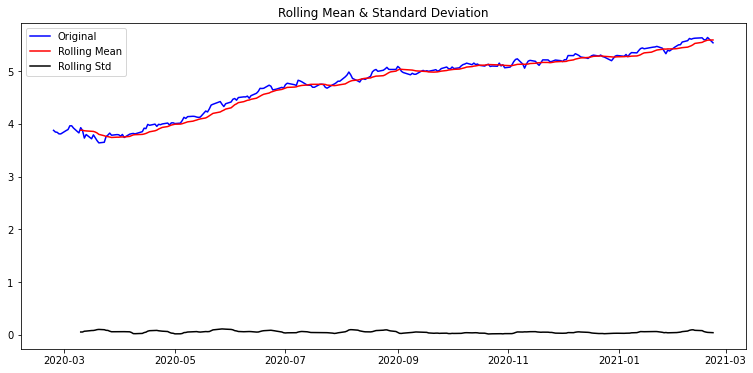

Results of Dickey-Fuller Test:
Test Statistic                  -1.012479
p-value                          0.748686
#Lags Used                       3.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


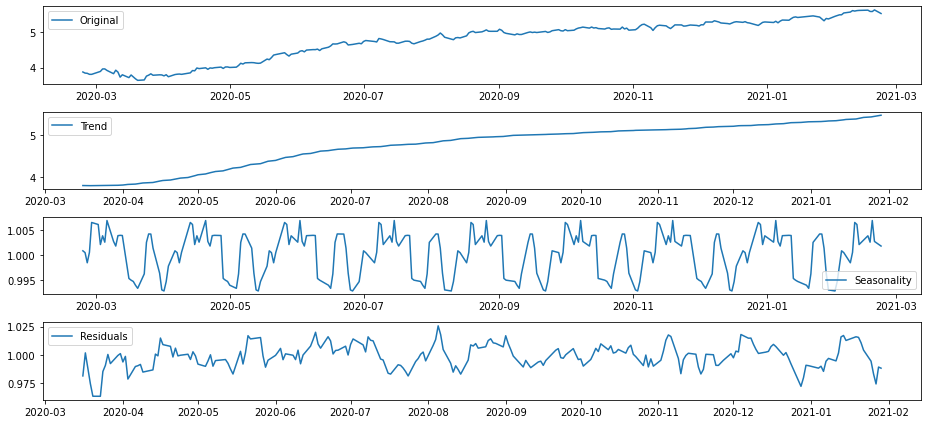

In [16]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [17]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.490807e+00
p-value                        1.228047e-08
#Lags Used                     5.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


p-value가 1 이상인 것으로 보아 안정성 데이터는 아닌것으로 파악됨 

## Step 4: 학습, 테스트 데이터셋 생성   
* 이제 미래에 대한 예측값이 나올 수 있도록 컴퓨터를 학습 시키고 테스트 하는 과정   
* 학습, 테스트 데이터셋 분리 

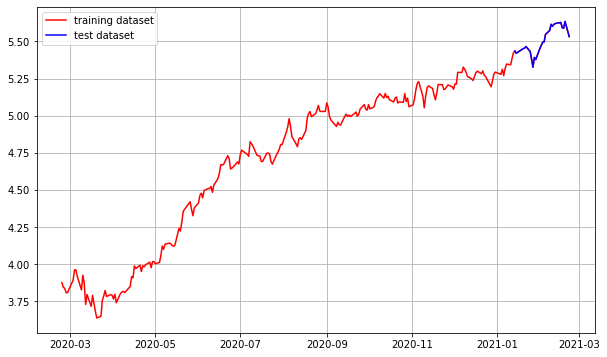

In [18]:
# 90%를 train시키는 학습, 테스트 데이터셋 생성 
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기   
* ACF, PACF 그려보기 -> p,q 구하기   

* 차분 안정성 확인 -> d 구하기



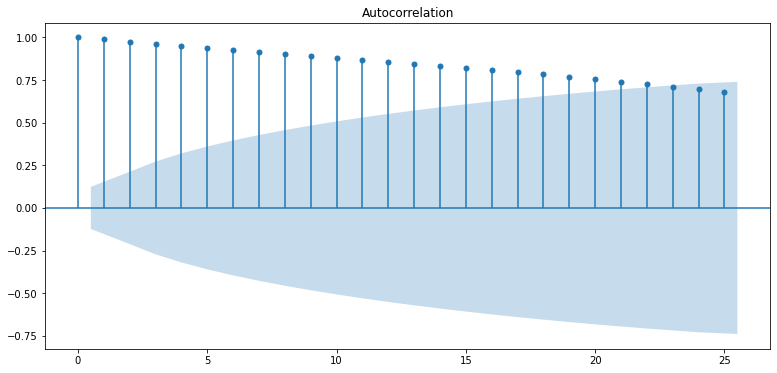

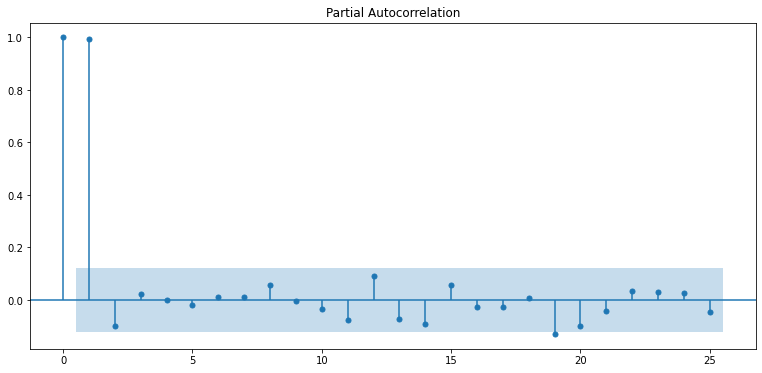

In [19]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.060746e+01
p-value                        5.951589e-19
#Lags Used                     2.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.148730e+00
p-value                        3.182064e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


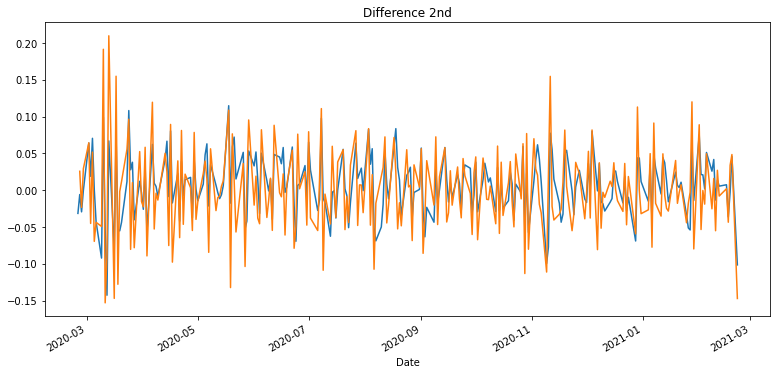

In [20]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트   
* ARIMA 모델 빌드와 훈련   

* 모델 테스트 및 플로팅   

* 최종 예측 모델 정확도 측정(MAPE)   



In [21]:
from statsmodels.tsa.arima_model import ARIMA

# 모델 만들기 
model = ARIMA(train_data, order=(1, 1, 0))  #p,q,c ? 순서임 
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 400.687
Method:                       css-mle   S.D. of innovations              0.041
Date:                Wed, 24 Feb 2021   AIC                           -795.374
Time:                        00:03:52   BIC                           -785.126
Sample:                             1   HQIC                          -791.238
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0069      0.003      2.589      0.010       0.002       0.012
ar.L1.D.Close    -0.0224      0.067     -0.336      0.737      -0.153       0.108
                                    Root

/home/ssac8/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac8/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

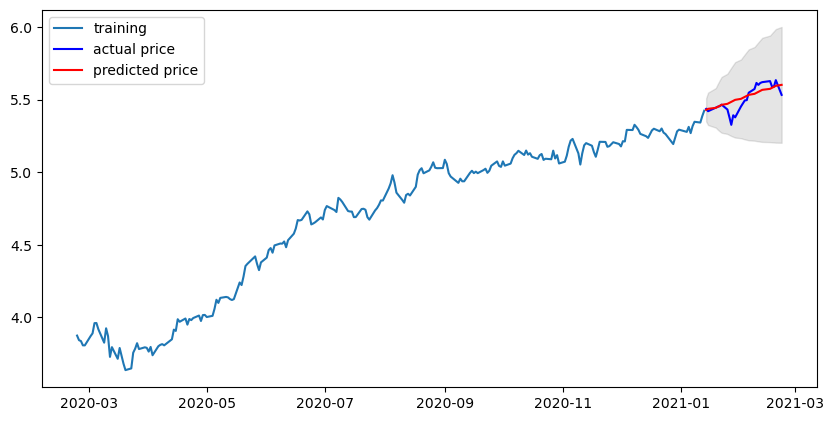

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [24]:
#MSE, MAE, RMSE, MAPE 값 뽑아내기 
# MAPE = Accuracy로 보면됨 

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  197.36708324016533
MAE:  10.675481208538429
RMSE:  14.048739560550096
MAPE: 4.47%


결과로 보아 실제 가격은 살짝 내려갔다가 반등하는 모습을 보여준 방면,   
Prediction의 경우 쭉 상한된다고 예측 하였다.    

----

## 두번째: SEA ADR 주식 예측 
## Step 1: 시계열 데이터 준비

In [25]:
# Time Series 생성
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/SE.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts2 = df['Close']

ts2.head()

Date
2020-02-24    48.200001
2020-02-25    46.700001
2020-02-26    46.419998
2020-02-27    45.070000
2020-02-28    45.060001
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행   
* 결측치 처리    
* 로그 변환   


In [28]:
# 결측치 처리
ts2=ts2.interpolate(method='time')
ts2[ts2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [29]:
# 로그 변환 시도 
ts2_log = np.log(ts2)

## STEP 3 : 시계열 안정성 분석   
* 정성적 그래프 분석 : 정기적으로 틀안에서 반복적으로 변하는지 분석   
* 정량적 Augmented Dicky-Fuller Test : 정성적인지 아닌지를 p-value를 통해서 알려줌. p-value가 작을 수록 정성적에 가까움   
* 시계열 분해 (Time Series Decomposition): 훨씬 간편하고 손쉬운 데이터의 정성화 방법! 
* Residual 안정성 확인 : 시계열 분해를 통해서 정성적으로 만들어지는 결과 부분


In [30]:
#일정 시간 내 구간 통계치 (Rolling Statistics)를 시각화 해보는 함수 

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [31]:
#Adfuller 메소드를 이용해서 timeseries에 대한 Augmented Dickey-fuller Test 수행 코드 
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


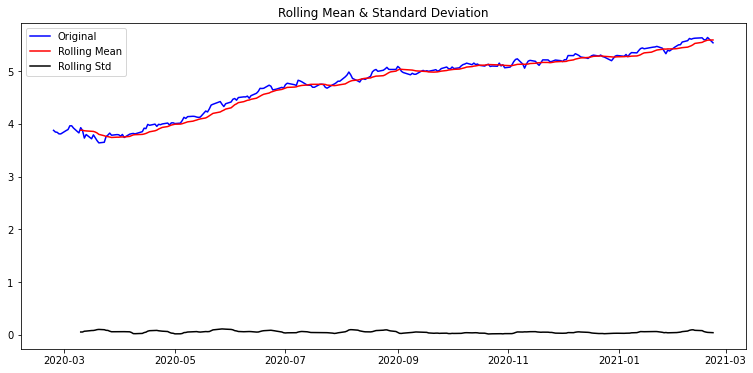

Results of Dickey-Fuller Test:
Test Statistic                  -1.012479
p-value                          0.748686
#Lags Used                       3.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


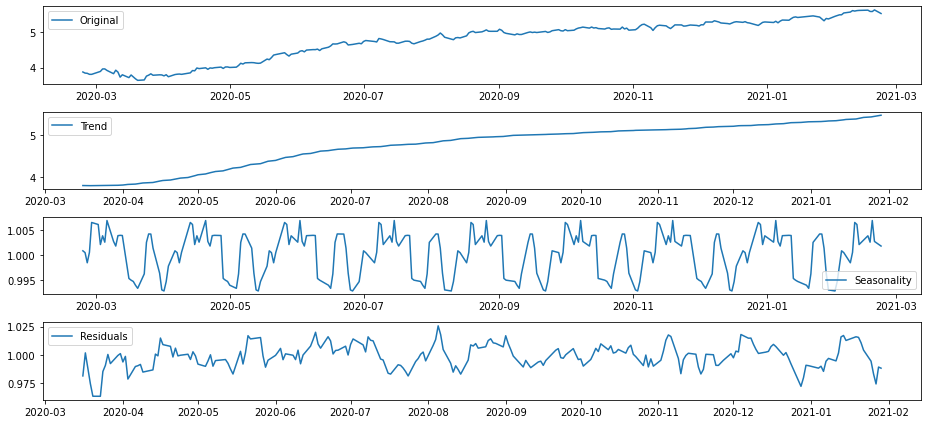

In [32]:
# 정성적 그래프 분석
plot_rolling_statistics(ts2_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts2_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [33]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.490807e+00
p-value                        1.228047e-08
#Lags Used                     5.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


p-value가 1 이상인 것으로 보아 안정성 데이터는 아닌것으로 파악됨 

## Step 4: 학습, 테스트 데이터셋 생성   
* 이제 미래에 대한 예측값이 나올 수 있도록 컴퓨터를 학습 시키고 테스트 하는 과정   
* 학습, 테스트 데이터셋 분리 

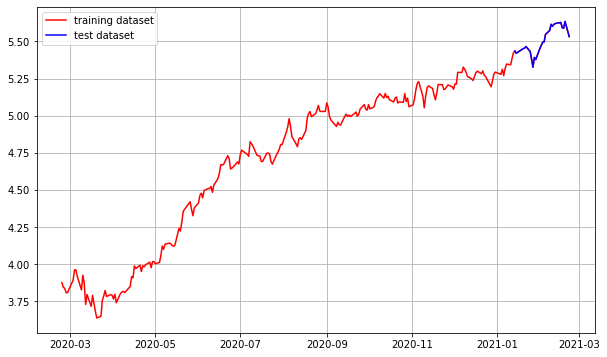

In [34]:
# 90%를 train시키는 학습, 테스트 데이터셋 생성 
train_data, test_data = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기   
* ACF, PACF 그려보기 -> p,q 구하기   

* 차분 안정성 확인 -> d 구하기



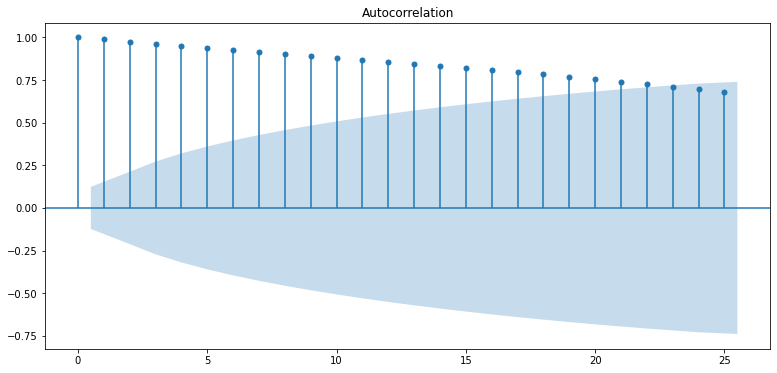

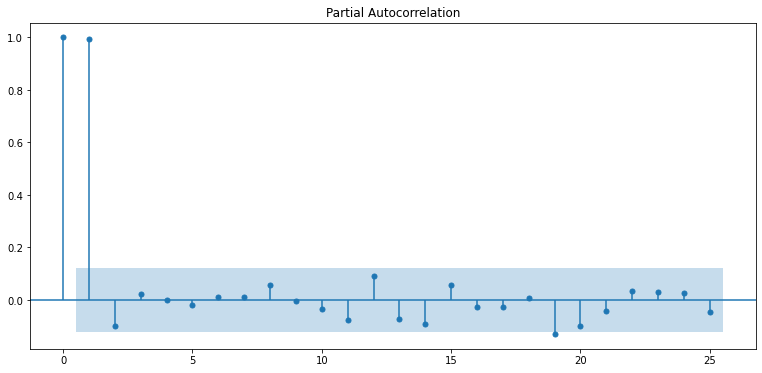

In [35]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.060746e+01
p-value                        5.951589e-19
#Lags Used                     2.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.148730e+00
p-value                        3.182064e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


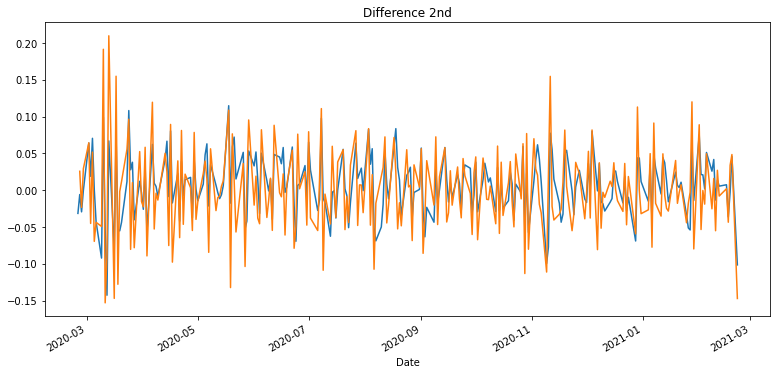

In [36]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트   
* ARIMA 모델 빌드와 훈련   

* 모델 테스트 및 플로팅   

* 최종 예측 모델 정확도 측정(MAPE)   



In [37]:
from statsmodels.tsa.arima_model import ARIMA

# 모델 만들기 
model = ARIMA(train_data, order=(1, 1, 0))  #p,q,c ? 순서임 
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 400.687
Method:                       css-mle   S.D. of innovations              0.041
Date:                Wed, 24 Feb 2021   AIC                           -795.374
Time:                        00:17:48   BIC                           -785.126
Sample:                             1   HQIC                          -791.238
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0069      0.003      2.589      0.010       0.002       0.012
ar.L1.D.Close    -0.0224      0.067     -0.336      0.737      -0.153       0.108
                                    Root

/home/ssac8/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac8/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

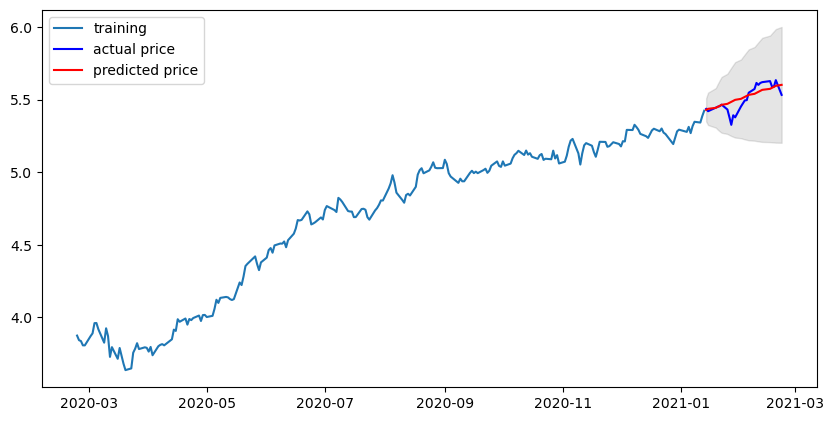

In [38]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [39]:
#MSE, MAE, RMSE, MAPE 값 뽑아내기 
# MAPE = Accuracy로 보면됨 

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  197.36708324016533
MAE:  10.675481208538429
RMSE:  14.048739560550096
MAPE: 4.47%


# step 4부터 그래프 모양이 너무 samsung이랑 똑같이 나옴..